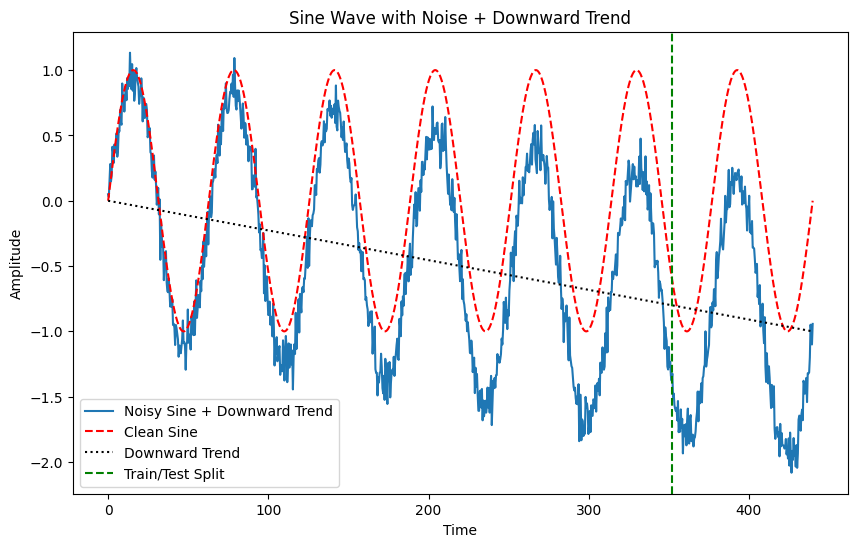

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

# 生成带噪声且带整体向下趋势的正弦波数据
num_samples = 1000
frequency = 0.1
noise_level = 0.1
trend_strength = 1.0   # 趋势强度（越大整体向下越明显）
seed = 42

np.random.seed(seed)
x = np.linspace(0, 140 * np.pi, num_samples)

# 正弦 + 噪声
clean_sine = np.sin(frequency * x)
noise = np.random.normal(0, noise_level, num_samples)

# 全局向下趋势（线性下降）
trend = -trend_strength * np.linspace(0, 1, num_samples)

# 合并：正弦 + 噪声 + 趋势
signal = clean_sine + noise + trend

# 转换为 PyTorch 张量
data = torch.from_numpy(signal).float()

# 划分训练/测试
train_size = int(0.8 * num_samples)
train_data = data[:train_size]
test_data  = data[train_size:]

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(x, signal, label='Noisy Sine + Downward Trend')
plt.plot(x, clean_sine, 'r--', label='Clean Sine')
plt.plot(x, trend, 'k:', label='Downward Trend')
plt.axvline(x=x[train_size], color='g', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('Sine Wave with Noise + Downward Trend')
plt.xlabel('Time'); plt.ylabel('Amplitude')
plt.show()

In [2]:
# 输入序列长度
seq_len = 20

# 处理训练数据，把切分序列后多余的部分去掉
train_num = len(train_data) // (seq_len + 1) * (seq_len + 1)

# 安全转换为 numpy，避免 numpy 2.0 的 copy 参数问题
train_data_np = (
    train_data[:train_num].detach().cpu().numpy().reshape(-1, seq_len + 1, 1)
)

np.random.seed(0)
torch.manual_seed(0)

x_train = train_data_np[:, :seq_len]          # (num_seq, seq_len, 1)
y_train = train_data_np[:, 1: seq_len + 1]    # (num_seq, seq_len, 1)
print(f'训练序列数：{len(x_train)}')

# 转为张量
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)

# 测试集按自回归预测：从 test_data[0] 开始，预测 len(y_test) 步
x_test = test_data[:-1]
y_test = test_data[1:]

训练序列数：38


In [3]:
import torch
import torch.nn as nn

# 超参数（与 GRU 对齐）
input_size = 1
output_size = 1
hidden_size = 16
learning_rate = 5e-4

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)  # batch_first=False
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # x: (B, T, C) -> (T, B, C) 以适配 nn.LSTM 默认 batch_first=False
        out, hidden = self.lstm(torch.transpose(x, 0, 1), hidden)  # out: (T, B, H)
        out = out.contiguous().view(-1, self.hidden_size)          # (T*B, H)
        out = self.linear(out)                                     # (T*B, C_out=1)
        return out, hidden

def _ensure_lstm_hidden(hidden):
    """
    将传入的 hidden 规范化为 (h, c) 形式，并确保维度是 [num_layers, B, H]。
    允许传入 None；或只传 h 张量（则自动构造同形状的 c=0）；或 (h, c) 元组。
    """
    if hidden is None:
        return None
    if isinstance(hidden, torch.Tensor):
        h = hidden
        if h.dim() == 2:  # [num_layers, H] -> [num_layers, 1, H]
            h = h.unsqueeze(1)
        c = torch.zeros_like(h)
        return (h, c)
    # tuple
    h, c = hidden
    if h.dim() == 2:
        h = h.unsqueeze(1)
    if c.dim() == 2:
        c = c.unsqueeze(1)
    return (h, c)

# LSTM 自回归测试：从 x0 开始单步滚动预测 pred_steps 步
def test_lstm(model, x0, hidden, pred_steps):
    hidden = _ensure_lstm_hidden(hidden)
    preds = []
    inp_t = x0.reshape(1, 1, input_size)  # (B=1, T=1, C=1)
    for _ in range(pred_steps):
        out, hidden = model(inp_t, hidden)      # out: (1, 1)
        preds.append(out.detach())
        inp_t = out.view(1, 1, input_size)      # 作为下一步输入
    return torch.concat(preds).reshape(-1)

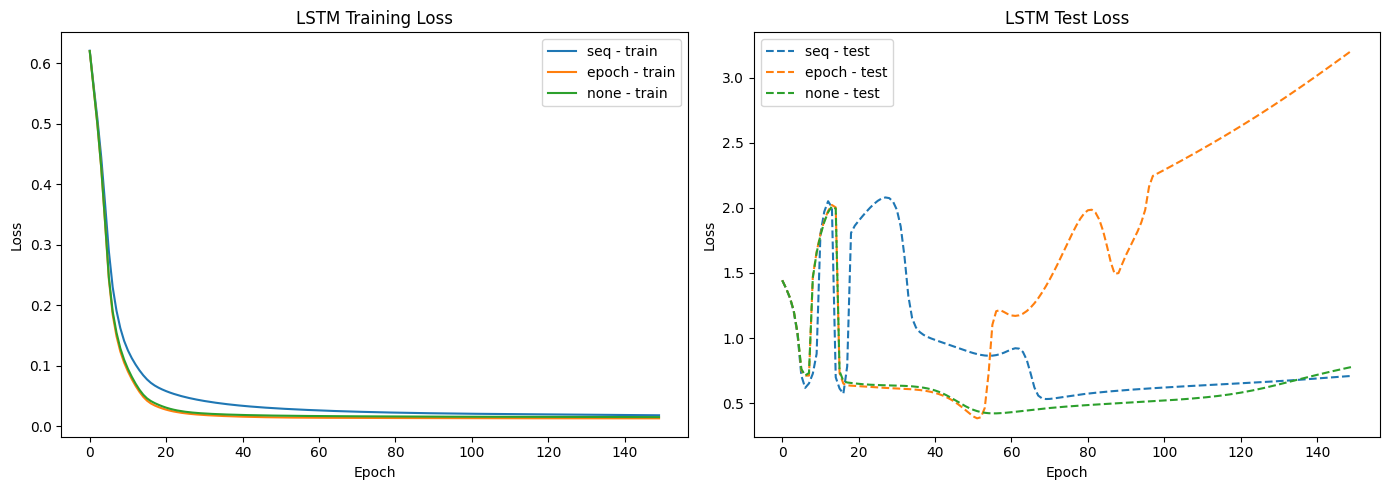

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm

max_epoch = 150
criterion = nn.functional.mse_loss

def train_one(reset_mode: str,
              max_epoch: int,
              model_ctor,
              optimizer_ctor,
              x_train, y_train,
              x_test, y_test,
              criterion):
    """
    reset_mode: 'seq' | 'epoch' | 'none'
    评估阶段统一用 init_hidden=None 做公平对比。
    """
    torch.manual_seed(0)  # 固定初始化，公平比较
    model = model_ctor()
    optim_ = optimizer_ctor(model.parameters())

    hidden_local = None  # (h, c) 或 None
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(max_epoch), leave=False, desc=f"mode={reset_mode}"):
        model.train()

        # 每个 epoch 是否重置
        if reset_mode == 'epoch':
            hidden_local = None

        epoch_loss = 0.0
        for X, Y in zip(x_train, y_train):
            # 每个序列是否重置
            if reset_mode == 'seq':
                hidden_local = None
            else:
                # 连续学习：保留状态，但 TBPTT 断开计算图
                if hidden_local is not None:
                    if isinstance(hidden_local, tuple):
                        hidden_local = (hidden_local[0].detach(), hidden_local[1].detach())
                    else:
                        hidden_local = hidden_local.detach()

            out, hidden_local = model(X[None, ...], hidden_local)
            loss = criterion(out.view(Y.shape), Y)
            optim_.zero_grad()
            loss.backward()
            optim_.step()
            epoch_loss += loss.item()

        epoch_loss /= len(x_train)
        train_losses.append(epoch_loss)

        # 测试统一用零初始；若要模拟在线预测，可改为 init_h = hidden_local
        model.eval()
        with torch.no_grad():
            init_h = None
            pred = test_lstm(model, x_test[0], init_h, len(y_test))
            t_loss = criterion(pred, y_test).item()
            test_losses.append(t_loss)

    return {
        'model': model,
        'hidden': hidden_local,
        'train_losses': train_losses,
        'test_losses': test_losses,
    }

# 构造器
def make_model():
    return LSTM(input_size, output_size, hidden_size)

def make_optim(params):
    return torch.optim.Adam(params, lr=learning_rate)

modes = ['seq', 'epoch', 'none']
results = {}
for m in modes:
    results[m] = train_one(
        reset_mode=m,
        max_epoch=max_epoch,
        model_ctor=make_model,
        optimizer_ctor=make_optim,
        x_train=x_train, y_train=y_train,
        x_test=x_test, y_test=y_test,
        criterion=criterion
    )

# 画训练/测试损失曲线
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for m in modes:
    plt.plot(results[m]['train_losses'], label=f'{m} - train')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('LSTM Training Loss'); plt.legend()

plt.subplot(1, 2, 2)
for m in modes:
    plt.plot(results[m]['test_losses'], label=f'{m} - test', linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('LSTM Test Loss'); plt.legend()

plt.tight_layout()
plt.show()

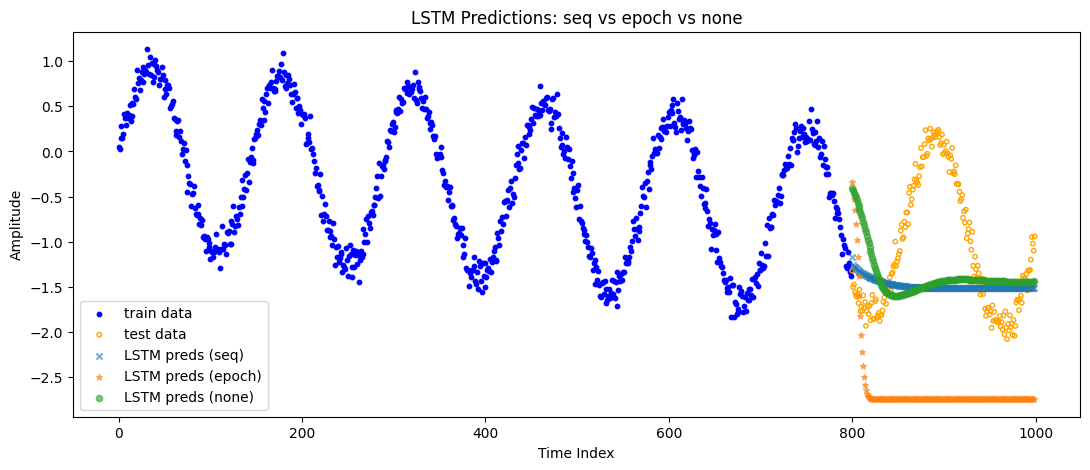

In [5]:
import numpy as np
import matplotlib.pyplot as plt

preds = {}
for m in modes:
    model = results[m]['model']
    model.eval()
    with torch.no_grad():
        init_h = None  # 改为 results[m]['hidden'] 可测试“训练末尾状态接续到测试”的在线场景
        preds[m] = test_lstm(model, x_test[0], init_h, len(y_test)).numpy()

dnp = data.numpy()

plt.figure(figsize=(13, 5))
# 真实数据
plt.scatter(np.arange(train_size), dnp[:train_size], color='blue', s=10, label='train data')
plt.scatter(np.arange(train_size, num_samples), dnp[train_size:], color='none',
            edgecolor='orange', s=10, label='test data')

# 三种预测
colors = {'seq': 'C0', 'epoch': 'C1', 'none': 'C2'}
markers = {'seq': 'x', 'epoch': '*', 'none': 'o'}
for m in modes:
    plt.scatter(np.arange(train_size, num_samples - 1), preds[m],
                color=colors[m], marker=markers[m], alpha=0.6, s=20,
                label=f'LSTM preds ({m})')

plt.legend(loc='lower left')
plt.title('LSTM Predictions: seq vs epoch vs none')
plt.xlabel('Time Index'); plt.ylabel('Amplitude')
plt.show()